In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

from math import sqrt

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../utilities/')
from helpers import *
from plots import *

# Load of training data

The ID indicates both the user and the item : user are identified as "r"+"index" from 1 to 10000, and items as "c"+ "index" from 1 to 1000. The format of the ID are consequently : r index(user) _ c index(item).
The ratings are given as integers from 1 to 5.

We compute them into a matrix with items as row and users as columns. All of the missing ratings are set as 0 and should be predicted to have a valid rating format.

In [3]:
DATA_TRAIN_PATH = '../Datasets/data_train.csv'
ratings = load_data(DATA_TRAIN_PATH)

number of items: 1000, number of users: 10000


In [4]:
ratings.shape

(1000, 10000)

# Data analysis

### Plot the number of ratings per movie and user

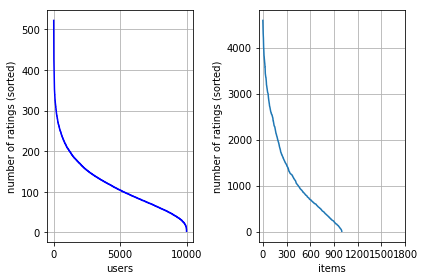

min # of items per user = 3, min # of users per item = 8.


In [5]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

Text(0, 0.5, 'counts')

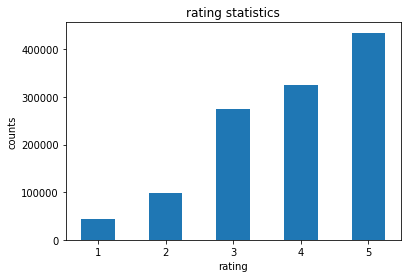

In [51]:
plt.hist(ratings.tocoo().data,np.linspace(0.75,5.25,10))
plt.title("rating statistics")
plt.xlabel("rating")
plt.ylabel("counts")

The number of ratings per movie correlates with average its rating.

Text(0, 0.5, 'average rating movie')

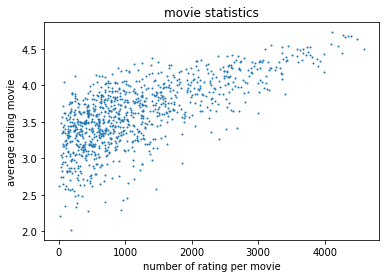

In [52]:
sum_ratings_movie = np.squeeze(np.asarray(ratings.sum(1)))    # sum of the nonzero elements, for each row
count_ratings_movie = np.diff(ratings.tocsr().indptr)         # count of the nonzero elements, for each row
average_movie_ratings = sum_ratings_movie/count_ratings_movie
    
plt.scatter(count_ratings_movie,average_movie_ratings,s=1)
plt.title("movie statistics")
plt.xlabel("number of rating per movie")
plt.ylabel("average rating movie")

The average rating a user gives, however, seems to be unrelated to how many movies he/she rated.

Text(0, 0.5, 'average rating user')

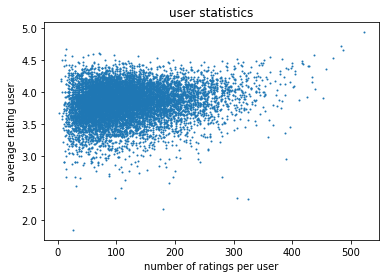

In [54]:
sum_ratings_user = np.squeeze(np.asarray(ratings.sum(0)))    # sum of the nonzero elements, for each row
count_ratings_user = np.diff(ratings.tocsc().indptr)         # count of the nonzero elements, for each row
average_ratings_user = sum_ratings_user/count_ratings_user
    
plt.scatter(count_ratings_user,average_ratings_user,s=1)
plt.title("user statistics")
plt.xlabel("number of ratings per user")
plt.ylabel("average rating user")

### Data preprocessing - Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # split the data and return train and test data.
    # we only consider users and movies that have more than 10 ratings

    ind_test = np.random.choice(valid_ratings.nnz, int(valid_ratings.nnz*p_test), replace=False)
    ind_train = np.delete(np.arange(valid_ratings.nnz),ind_test)
    
    valid_ratings_coo = valid_ratings.tocoo()
    data = valid_ratings_coo.data
    row = valid_ratings_coo.row
    col = valid_ratings_coo.col
    
    test = sp.coo_matrix((data[ind_test], (row[ind_test], col[ind_test])), shape=valid_ratings.get_shape())
    train = sp.coo_matrix((data[ind_train], (row[ind_train], col[ind_train])), shape=valid_ratings.get_shape()) 
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


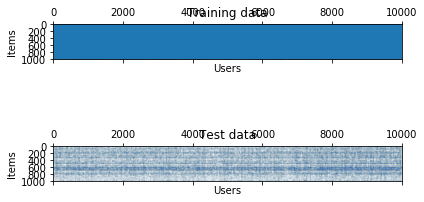

In [7]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

# Standard implementations

## Implementing Baselines 

### Use the global mean to do the prediction

In [8]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""  
    
    return sqrt(calculate_mse(test.data,np.mean(train.data))/(test.nnz))

baseline_global_mean(train, test)

1.1167843007553209

### Use the user means as the prediction

In [10]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over nth user
    sum_ratings_movie = np.squeeze(np.asarray(train.sum(0)))    # sum of the nonzero elements, for each row
    count_ratings_movie = np.diff(train.tocsc().indptr)         # count of the nonzero elements, for each row
    mean_rating_movie = sum_ratings_movie/count_ratings_movie
    return sqrt(calculate_mse(test.data,mean_rating_movie[test.col])/(test.nnz))

baseline_user_mean(train, test)

1.0943344686705307

### Use the item means as prediction

In [11]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over dth movie
    sum_ratings_user = np.squeeze(np.asarray(train.sum(1)))    # sum of the nonzero elements, for each row
    count_ratings_user = np.diff(train.tocsr().indptr)         # count of the nonzero elements, for each row
    mean_rating_user = sum_ratings_user/count_ratings_user

    return sqrt(calculate_mse(test.data,mean_rating_user[test.row])/(test.nnz))
    
baseline_item_mean(train, test)

1.0292360165304137

### Use both user and item indices for linear prediction

1.0002486362462182


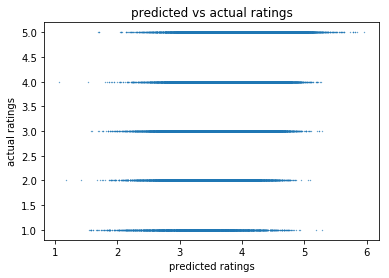

In [12]:
from scipy.sparse.linalg import spsolve

def baseline_item_user(train, test):
    """baseline method: find best parameters for the model y_dn = w_0 + w_item[d] + w_user[n] (D+N+1) parameters
       and make a prediction."""
    
    global_mean = np.mean(train.data)
    
    #Sum over nth user
    sum_ratings_movie = np.squeeze(np.asarray(train.sum(0)))    # sum of the nonzero elements, for each row
    count_ratings_movie = np.diff(train.tocsc().indptr)         # count of the nonzero elements, for each row
    
    #Sum over dth movie
    sum_ratings_user = np.squeeze(np.asarray(train.sum(1)))    # sum of the nonzero elements, for each col
    count_ratings_user = np.diff(train.tocsr().indptr)         # count of the nonzero elements, for each col
    
    num_items, num_users = train.shape
    
    # Constructing linear system defining the model's optimal parameters in form of a matrix
    
    # Matrix of the same shape as ratings, 1 if rating present, 0 otherwise
    mask_train = sp.coo_matrix((np.ones(train.nnz), (train.row, train.col)), shape=train.shape) 
    
    A = sp.hstack((sp.diags(count_ratings_user), mask_train))
    A = sp.vstack((A, sp.hstack((mask_train.T, sp.diags(count_ratings_movie)))))
    A = sp.hstack((A, sp.coo_matrix(np.concatenate((count_ratings_movie,count_ratings_user))).T))
    A = sp.vstack((A, sp.coo_matrix(np.ones(num_items+num_users+1))))
    
    b = np.append(np.concatenate((sum_ratings_user, sum_ratings_movie)),global_mean)
    
    # Solving the system
    x = spsolve(A.tocsc(),b)
    
    # Extracting the parameters w_0, w_item[d] and w_user[n] 
    w_item, w_user, w_0 = np.split(x,np.array([num_items,num_items+num_users]))
    

    
    rmse_te = sqrt(calculate_mse(test.data, w_item[test.row] + w_user[test.col] + w_0)/(test.nnz))
    
    return rmse_te, w_item, w_user, w_0

    
rmse_te, w_item, w_user, w_0 = baseline_item_user(train, test)

print(rmse_te)

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(w_item[test.row] + w_user[test.col] + w_0, test.data,s=0.1)

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [13]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # returns initialized with random values :
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item

    
    max_initial_value = 2*sqrt(np.mean(train.data)/num_features)
    
    user_features = max_initial_value*np.random.rand(num_features, train.shape[1])
    item_features = max_initial_value*np.random.rand(num_features, train.shape[0])

    
    return user_features,item_features

#### Compute errors

In [14]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # calculate rmse (we only consider nonzero entries.)
    approx_data_matrix = np.dot(item_features.T,user_features)
    return sqrt(calculate_mse(data,approx_data_matrix[nz])/(len(data)))

Since the ratings can only take values between 1 and 5, the RMSE will be smaller if all predictions that exceed this range are set to 1 and five respectively.

In [34]:
def compute_cliped_predictions(user_features,item_features):
    """sets the prediction of ratings below 1 and above 5 to 1 and 5,respectively."""
    approx_data_matrix = np.dot(item_features.T,user_features)
    approx_data_matrix[approx_data_matrix > 5] = 5;
    approx_data_matrix[approx_data_matrix < 1] = 1;

    return approx_data_matrix

In [35]:
def compute_clipped_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the clipped prediction of nonzero elements."""
    approx_data_matrix = compute_cliped_predictions(user_features, item_features)
    return sqrt(calculate_mse(data,approx_data_matrix[nz])/(len(data)))

The matrix factorization with a limited number of variables can approximate the actual ratings only up to a certain point. The predicted ratings are continuous. One could imagine that the error of a good prdictor gets lower if the predictions are discretized if the lie close to an integer value.

In [47]:
def compute_cliped_discretized_predictions(user_features,item_features):
    """clips the prediction of ratings below 1 to 1 or above 5 to 5 and inbetween clips 
     prediction near an integer to that integer."""
    approx_data_matrix = np.dot(item_features.T,user_features)
    approx_data_matrix[approx_data_matrix>4.9]=5;
    approx_data_matrix[approx_data_matrix<1.1]=1;
    approx_data_matrix[np.all([approx_data_matrix>1.9, approx_data_matrix<2.1],axis=0)]=2;
    approx_data_matrix[np.all([approx_data_matrix>2.9, approx_data_matrix<3.1],axis=0)]=3;
    approx_data_matrix[np.all([approx_data_matrix>3.9, approx_data_matrix<4.1],axis=0)]=4;

    return approx_data_matrix

In [46]:
def compute_clipped_discretized_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the clipped prediction of nonzero elements."""
    approx_data_matrix = compute_cliped_discretized_predictions(user_features, item_features)
    return sqrt(calculate_mse(data,approx_data_matrix[nz])/(len(data)))

#### Matrix factorization SGD basic

In [19]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.05
    num_features = 25   # K in the lecture notes
    num_epochs = 15     # number of full iterations through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col, train.data))

    print("learn the matrix factorization using SGD...")
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.     

            item_features[:,d] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]
            user_features[:,n] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        errors.append(rmse_te)

    # evaluate the test error.
    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.0679046970987307, RMSE on testing set: 1.1028435045814358.
iter: 1, RMSE on training set: 1.0398990908929941, RMSE on testing set: 1.099446723942877.
iter: 2, RMSE on training set: 1.0125700340876733, RMSE on testing set: 1.0992430579902652.
iter: 3, RMSE on training set: 0.9801143045638457, RMSE on testing set: 1.0897487023745898.
iter: 4, RMSE on training set: 0.9599319652659296, RMSE on testing set: 1.0895473003152187.
iter: 5, RMSE on training set: 0.9372145629218471, RMSE on testing set: 1.0866542383792985.
iter: 6, RMSE on training set: 0.9194893273989491, RMSE on testing set: 1.0844204652400975.
iter: 7, RMSE on training set: 0.9075187856642151, RMSE on testing set: 1.084446880114519.
iter: 8, RMSE on training set: 0.8955459892911152, RMSE on testing set: 1.0811626507524534.
iter: 9, RMSE on training set: 0.884925

#### Matrix factorization SGD regularized

In [20]:
def matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion):
    """matrix factorization by SGD."""
    
    # set seed
    np.random.seed(seed)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices  
    nz_train = list(zip(train.row, train.col, train.data))
    
    print("learn the matrix factorization using SGD...")
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_error(test.data, user_features, item_features, test.nonzero())]
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= gamma_dec_step_size
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.

            item_features[:,d] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]-lambda_item*item_features[:,d])
            user_features[:,n] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]-lambda_user*user_features[:,n])
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
            
    # evaluate the test error.
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te


In [21]:
# define parameters 
num_features = 40   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gamma = 0.05
gamma_dec_step_size = 1.2
num_epochs = 15     # number of full passes through the train set
stop_criterion = 1e-4
    
seed = 988

matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion)


learn the matrix factorization using SGD...
initial RMSE on training set: 1.2390613923769698, RMSE on testing set: 1.2372345918205176.
iter: 0, RMSE on training set: 1.0588242461230786, RMSE on testing set: 1.0773640743570123.
iter: 1, RMSE on training set: 1.038409837365067, RMSE on testing set: 1.0604153282512494.
iter: 2, RMSE on training set: 1.0262790658245189, RMSE on testing set: 1.0491782269277674.
iter: 3, RMSE on training set: 1.0158464414628225, RMSE on testing set: 1.0443800488180899.
iter: 4, RMSE on training set: 0.9978089982393074, RMSE on testing set: 1.0302138915846641.
iter: 5, RMSE on training set: 0.9826293271784594, RMSE on testing set: 1.0202782787630051.
iter: 6, RMSE on training set: 0.9700711337597688, RMSE on testing set: 1.012251534794236.
iter: 7, RMSE on training set: 0.9637524449439893, RMSE on testing set: 1.0092944182583956.
iter: 8, RMSE on training set: 0.956877617856096, RMSE on testing set: 1.0052946028335745.
iter: 9, RMSE on training set: 0.9508067

0.992832495004245

##### Tuning Hyperparameters - gamma & decrement

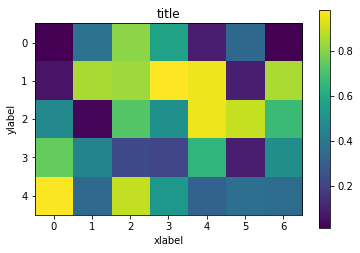

In [24]:
def plot_simple_heatmap(data, title, xlabel, xticklabels, ylabel, yticklabels):

    f,a = plt.subplots()
    a.set_xlabel(xlabel)
    a.set_xticks(range(len(xticklabels)))
    a.set_xticklabels(xticklabels)
    a.set_ylabel(ylabel)
    a.set_yticks(range(len(yticklabels)))
    a.set_yticklabels(yticklabels)
    a.set_title(title)
    heatmap_corr = a.imshow(data)
    f.colorbar(heatmap_corr, ax=a)
    
data = np.random.rand(5,7)
plot_simple_heatmap(data, "title", "xlabel",np.arange(7), "ylabel",np.arange(5))

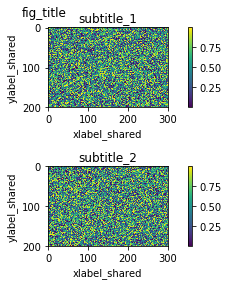

In [22]:
def plot_simple_heatmaps(data_1, data_2, fig_title, subtitle_1, subtitle_2, xlabel_shared, ylabel_shared):

    f,a = plt.subplots(2,1)
    
    a[0].set_xlabel(xlabel_shared)
    a[0].set_ylabel(ylabel_shared)
    a[0].set_title(subtitle_1)
    heatmap_0 = a[0].imshow(data_1)

    a[1].set_xlabel(xlabel_shared)
    a[1].set_ylabel(ylabel_shared)
    a[1].set_title(subtitle_2)
    heatmap_1 = a[1].imshow(data_2)

    plt.tight_layout()
    
    f.colorbar(heatmap_0,ax=a[0])
    f.colorbar(heatmap_1,ax=a[1])
    
    f.suptitle(fig_title)
    
data_1 = np.random.rand(200,300)
data_2 = np.random.rand(200,300)
plot_simple_heatmaps(data_1, data_2, 'fig_title', 'subtitle_1', 'subtitle_2', 'xlabel_shared', 'ylabel_shared')

Finding the best initial gamma and the best decrement step size to compare SGD with ALS.

In [ ]:
"""
# define parameters 
num_features = 25   # K in the lecture notes

lambda_user = 0.08
lambda_item = 0.08
    
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)


num_epochs = 30     # number of full passes through the train set
stop_criterion = 1e-4
    
seeds = np.array([988,1000])
#seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(gammas),len(gamma_dec_step_sizes)))

for ind_seed, seed in enumerate(seeds):
    for ind_gamma, gamma in enumerate(gammas):
        for ind_gamma_dec_step_size, gamma_dec_step_size in enumerate(gamma_dec_step_sizes):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("gamma ({}/{}) = {}".format(ind_gamma+1, len(gammas), gamma))
            print("stepsize decrement ({}/{}) = {}".format(ind_gamma_dec_step_size+1, len(gamma_dec_step_sizes), gamma_dec_step_size))
            
            rmse_te[ind_seed,ind_gamma,ind_gamma_dec_step_size] = matrix_factorization_SGD_regularized(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_gammas',rmse_te)
"""

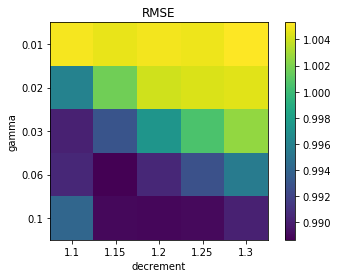

In [26]:
RMSE_test_tuning_gammas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_gammas.npy')
gammas = np.logspace(-2,-1,num = 5)
gamma_dec_step_sizes = np.linspace(1.1,1.3,5)
plot_simple_heatmap(np.min(RMSE_test_tuning_gammas, axis = 0), "RMSE", "decrement",np.around(gamma_dec_step_sizes,2), "gamma",np.around(gammas,2))
plt.savefig('../plots/heatmap_tuning_gammas.png')

In [45]:
argmin_over_gammas = np.argmin(np.min(RMSE_test_tuning_gammas, axis = 0), axis = 0)
argmin_global = np.argmin(RMSE_test_tuning_lambdas[argmin_over_gammas,np.arange(len(gamma_dec_step_sizes))], axis = 0)
gamma_dec_star = gamma_dec_step_sizes[argmin_global]
gamma_star = gammas[argmin_over_gammas[argmin_global]]
print("The decrement step is : {dec:1.2f} and the best gamma is {g:0.3f}".format(dec = gamma_dec_star,g = gamma_star))
print("The corresponding error is : {err:1.4f}".format(err = np.min(np.min(RMSE_test_tuning_gammas, axis = 0))))

The decrement step is : 1.15 and the best gamma is 0.056
The corresponding error is : 0.9886


### Learn the Matrix Factorization using Alternating Least Squares

In [36]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""

    # update and return user feature.
    user_features = np.zeros((item_features.shape[0],train.shape[1]))
    
    for n in range(train.shape[1]):
        
        item_features_n = np.zeros(item_features.shape)
        item_features_n[:,nz_user_itemindices[n]] = item_features[:,nz_user_itemindices[n]]
        user_features[:,n] = np.linalg.solve(np.dot(item_features_n,item_features.T)+lambda_user*nnz_items_per_user[n]*np.identity(user_features.shape[0]),np.dot(item_features,np.squeeze(np.asarray(train.getcol(n).todense()))))
    
    return user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""

    # update and return item feature.
    item_features = np.zeros((user_features.shape[0],train.shape[0]))
    
    for d in range(train.shape[0]):
        
        user_features_d = np.zeros(user_features.shape)
        user_features_d[:,nz_item_userindices[d]] = user_features[:,nz_item_userindices[d]]
        item_features[:,d] = np.linalg.solve(np.dot(user_features_d,user_features.T)+lambda_item*nnz_users_per_item[d]*np.identity(user_features.shape[0]),np.dot(user_features,np.squeeze(np.asarray(train.getrow(d).todense()))))
    
    return item_features

In [37]:
def ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    
    # set seed
    np.random.seed(seed)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # start you ALS-WR algorithm. 
    
    nz_row, nz_col = train.nonzero()
    
    nz_user_itemindices = [nz_row[nz_col==n] for n in range(train.shape[1])]
    nnz_items_per_user = np.array([len(nz_user_itemindice) for nz_user_itemindice in nz_user_itemindices])
    nz_item_userindices = [nz_col[nz_row==d] for d in range(train.shape[0])]
    nnz_users_per_item = np.array([len(nz_item_userindice) for nz_item_userindice in nz_item_userindices])
    
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_clipped_error(test.data, user_features, item_features, test.nonzero())]
    print("initial: RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    

    for it in range(max_iter):
        
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_clipped_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
        
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te


In [38]:
# define parameters
num_features = 25   # K in the lecture notes
lambda_user = 0.08
lambda_item = 0.08
stop_criterion = 1e-4
max_iter = 30

seeds = 988

ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed)

initial: RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.289329145914807.
iter: 0, RMSE on training set: 0.9519054032723246, RMSE on testing set: 1.0176368655383672.
iter: 1, RMSE on training set: 0.9315802604917478, RMSE on testing set: 1.0032528566782488.
iter: 2, RMSE on training set: 0.9100196143174027, RMSE on testing set: 0.9968063131112256.
iter: 3, RMSE on training set: 0.8978135873998376, RMSE on testing set: 0.9934353989724883.
iter: 4, RMSE on training set: 0.8908915580800574, RMSE on testing set: 0.9916363454956203.
iter: 5, RMSE on training set: 0.8865317019111828, RMSE on testing set: 0.9904812172337789.
iter: 6, RMSE on training set: 0.8836344304523723, RMSE on testing set: 0.9897093274161839.
iter: 7, RMSE on training set: 0.8816238424159367, RMSE on testing set: 0.9891886823301141.
iter: 8, RMSE on training set: 0.8801742015688895, RMSE on testing set: 0.9888321834125177.
iter: 9, RMSE on training set: 0.8790928220247602, RMSE on testing set: 0.9885808

0.9874586274136775

##### Tuning Hyperparameters - lambda user & lambda item

Finding the best ridge parameters using ALS

In [ ]:
"""
# define parameters 
num_features = 25   # K in the lecture notes
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
stop_criterion = 1e-4
max_iter = 15
    
seeds = np.array([988])

rmse_te = np.zeros((len(seeds),len(lambda_users),len(lambda_items)))

for ind_seed, seed in enumerate(seeds):
    for ind_lambda_user, lambda_user in enumerate(lambda_users):
        for ind_lambda_item, lambda_item in enumerate(lambda_items):
            print("seed ({}/{}) = {}".format(ind_seed+1, len(seeds), seed))
            print("lambda_user ({}/{}) = {}".format(ind_lambda_user+1, len(lambda_users), lambda_user))
            print("lambda_item ({}/{}) = {}".format(ind_lambda_item+1, len(lambda_items), lambda_item))
            
            rmse_te[ind_seed,ind_lambda_user,ind_lambda_item] = ALS(train, test, num_features, lambda_user, lambda_item, max_iter, seed)

np.save('../results_of_lengthy_computations/RMSE_test_tuning_lambdas',rmse_te)
"""

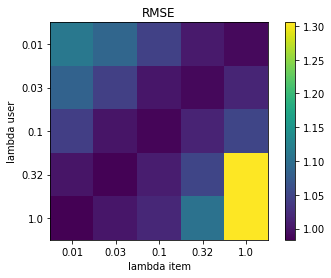

In [56]:
RMSE_test_tuning_lambdas = np.load('../results_of_lengthy_computations/RMSE_test_tuning_lambdas.npy')
lambda_users = np.logspace(-2,0,num = 5)
lambda_items = np.logspace(-2,0,num = 5)
plot_simple_heatmap(RMSE_test_tuning_lambdas, "RMSE", "lambda item",np.around(lambda_items,2), "lambda user",np.around(lambda_users,2))
plt.savefig('../plots/heatmap_tuning_lambdas.png')

In [57]:
argmin_over_lambda_users = np.argmin(RMSE_test_tuning_lambdas, axis = 0)
argmin_global = np.argmin(RMSE_test_tuning_lambdas[argmin_over_lambda_users,np.arange(len(lambda_items))], axis = 0)
lambda_item_star = lambda_items[argmin_global]
lambda_user_star = lambda_users[argmin_over_lambda_users[argmin_global]]
print("The best lambda item is : {} and the best lambda user is {}".format(lambda_item_star,lambda_user_star))
print("The corresponding error is : {err:1.4f}".format(err = np.min(RMSE_test_tuning_lambdas)))

The best lambda item is : 0.01 and the best lambda user is 1.0
The corresponding error is : 0.9833


### Prediction SGD & ALS with tuned parameters

In [39]:
def matrix_factorization_SGD_regularized_predict(train, test, num_features, lambda_user, lambda_item, gamma, gamma_dec_step_size, num_epochs, seed, stop_criterion):
    """matrix factorization by SGD."""
    
    # set seed
    np.random.seed(seed)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    best_user_features = np.copy(user_features)
    best_item_features = np.copy(item_features)
    
    # find the non-zero ratings indices  
    nz_train = list(zip(train.row, train.col, train.data))
    
    print("learn the matrix factorization using SGD...")
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_error(test.data, user_features, item_features, test.nonzero())]
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= gamma_dec_step_size
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.

            item_features[:,d] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]-lambda_item*item_features[:,d])
            user_features[:,n] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]-lambda_user*user_features[:,n])
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if rmse_tr[-1] < min(rmse_tr[:-1]):
            best_user_features = np.copy(user_features)
            best_item_features = np.copy(item_features)
            
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
            
    # evaluate the test error.
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te, best_user_features, best_item_features

In [40]:
def ALS_pred(train, test, num_features, lambda_user, lambda_item, max_iter, seed):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    
    # set seed
    np.random.seed(seed)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    best_user_features = np.copy(user_features)
    best_item_features = np.copy(item_features)
    
    # start you ALS-WR algorithm. 
    
    nz_row, nz_col = train.nonzero()
    
    nz_user_itemindices = [nz_row[nz_col==n] for n in range(train.shape[1])]
    nnz_items_per_user = np.array([len(nz_user_itemindice) for nz_user_itemindice in nz_user_itemindices])
    nz_item_userindices = [nz_col[nz_row==d] for d in range(train.shape[0])]
    nnz_users_per_item = np.array([len(nz_item_userindice) for nz_item_userindice in nz_item_userindices])
    
    rmse_tr = [compute_error(train.data, user_features, item_features, train.nonzero())]
    rmse_te = [compute_clipped_error(test.data, user_features, item_features, test.nonzero())]
    print("initial: RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr[0],rmse_te[0]))
    

    for it in range(max_iter):
        
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        
        
        rmse_tr.append(compute_error(train.data, user_features, item_features, train.nonzero()))
        rmse_te.append(compute_clipped_error(test.data, user_features, item_features, test.nonzero()))
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr[-1],rmse_te[-1]))
        
        if rmse_te[-1] < min(rmse_te[:-1]):
            best_user_features = np.copy(user_features)
            best_item_features = np.copy(item_features)
        
        if np.isclose(rmse_tr[-1],rmse_tr[-2],stop_criterion) or rmse_tr[-1] > rmse_tr[0]:
            break
        
    min_rmse_te = min(rmse_te)
    print("RMSE on test data: {}.".format(min_rmse_te))
    
    return min_rmse_te, best_user_features, best_item_features

In [50]:
# define parameters 
num_features = 25   # K in the lecture notes    
seed = 988
num_epochs = 30     # number of full passes through the train set
stop_criterion = 1e-4
max_iter = 15

min_rmse_te_SGD, best_user_features_SGD, best_item_features_SGD = matrix_factorization_SGD_regularized_predict(train, test, num_features, lambda_user_star, lambda_item_star, gamma_star, gamma_dec_star, num_epochs, seed, stop_criterion)
min_rmse_te_ALS, best_user_features_ALS, best_item_features_ALS = ALS_pred(train, test, num_features, lambda_user_star, lambda_item_star, max_iter, seed)


learn the matrix factorization using SGD...
initial RMSE on training set: 1.3071287373574476, RMSE on testing set: 1.3052388688004901.
iter: 0, RMSE on training set: 1.2804128112146969, RMSE on testing set: 1.2921882934989557.
iter: 1, RMSE on training set: 1.2598715055806557, RMSE on testing set: 1.2676771007912275.
iter: 2, RMSE on training set: 1.2293768943084653, RMSE on testing set: 1.239354113046117.
iter: 3, RMSE on training set: 1.2099015935248405, RMSE on testing set: 1.22021148531272.
iter: 4, RMSE on training set: 1.1836584111807802, RMSE on testing set: 1.1933089853575036.
iter: 5, RMSE on training set: 1.1620249236228821, RMSE on testing set: 1.1754710208848675.
iter: 6, RMSE on training set: 1.1314273548378626, RMSE on testing set: 1.1466186110869152.
iter: 7, RMSE on training set: 1.1164371151679229, RMSE on testing set: 1.1331662983835737.
iter: 8, RMSE on training set: 1.0987146648443278, RMSE on testing set: 1.1142508172309138.
iter: 9, RMSE on training set: 1.0835417

SGD - clipped test RMSE: 0.9966999084836952,clipped discretized test RMSE: 0.9972448856852125.


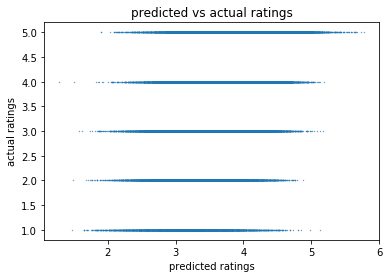

In [58]:
clipped_RMSE_SGD = compute_clipped_error(test.data, best_user_features_SGD, best_item_features_SGD, test.nonzero())
clipped_discretized_RMSE_SGD = compute_clipped_discretized_error(test.data, best_user_features_SGD, best_item_features_SGD, test.nonzero())
print("SGD - clipped test RMSE: {},clipped discretized test RMSE: {}.".format(clipped_RMSE_SGD,clipped_discretized_RMSE_SGD))

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(np.dot(best_item_features_SGD.T,best_user_features_SGD)[test.nonzero()], test.data,s=0.1)

ALS - clipped test RMSE: 0.9842601676448772,clipped discretized test RMSE: 0.9846860300603074.


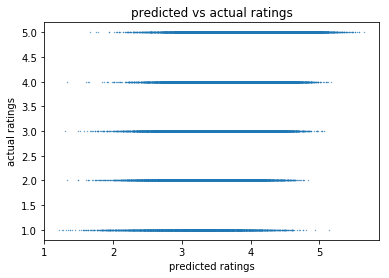

In [59]:
clipped_RMSE_ALS = compute_clipped_error(test.data, best_user_features_ALS, best_item_features_ALS, test.nonzero())
clipped_discretized_RMSE_ALS = compute_clipped_discretized_error(test.data, best_user_features_ALS, best_item_features_ALS, test.nonzero())
print("ALS - clipped test RMSE: {},clipped discretized test RMSE: {}.".format(clipped_RMSE_ALS,clipped_discretized_RMSE_ALS))

# Plot prediction versus test values
plt.title("predicted vs actual ratings")
plt.xlabel("predicted ratings")
plt.ylabel("actual ratings")
plt.scatter(np.dot(best_item_features_ALS.T,best_user_features_ALS)[test.nonzero()], test.data,s=0.1)

- test and train

- kmean. surely not the most efficient method
- matrix factorizations
- neural network

# Output

In [ ]:
OUTPUT_PATH = '../Datasets/sample_submission.csv'
pred_submission =
create_csv_submission(ids_test, pred_submission, OUTPUT_PATH)
raise NotImplementedError